In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1008. InVitroWildfire EVProteomics Culture Comparison/P1008.3. Analyses/P1008.3.5. PDF NTA Data Visualization/Output')
cur_date = "070623"

library(readxl)
library(tidyverse)
library(MetBrewer)
library(car)
library(openxlsx)

#reading in file
pdf_data = data.frame(read_excel("Input/Wildfire_InVitro_NTA_data_030421.xlsx")) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




In [2]:
head(pdf_data)

,Sample.Identifier.NTA.PDF,Group.Label,Original.Concentration..Particles..µL.,Particle.Count,X10,X50,X90,Charge..mV.
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20220201_0000_sample1_size,Co-culture unexposed,2.1e+06,1.05e+08,79.0,132.7,202.9,-8.18
2,20220201_0008_sample2_size,Co-culture unexposed,4.1e+06,2.05e+08,79.3,137.0,230.7,-19.40
3,20220201_0016_sample3_size,Co-culture unexposed,6.8e+06,3.40e+08,77.8,134.7,223.6,-21.55
4,20220201_0026_sample4_size,Co-culture unexposed,7.8e+06,3.90e+08,65.2,116.7,207.7,-5.71
5,20220202_0000_sample5_size,Co-culture unexposed,2.3e+06,1.15e+08,76.2,122.5,224.7,-24.52
6,20220202_0009_sample6_size,Co-culture unexposed,1.6e+07,8.00e+08,82.5,137.7,241.8,-27.16


In [3]:
longer_pdf_data = pdf_data %>% 
    #removing 2 values with missing group labels
    drop_na() %>%
    pivot_longer(cols = 3:8, names_to = "Variable", values_to = "Value") %>%
    # removing exposed groups
    filter(grepl("unexposed", Group.Label)) %>%
    mutate(Group.Label = ifelse(grepl("Co-culture unexposed", Group.Label), "Co-culture", "Tri-culture"))

#making group labels and variable into a factor
longer_pdf_data$Group.Label = factor(longer_pdf_data$Group.Label, levels = c("Tri-culture", "Co-culture"))
longer_pdf_data$Variable = factor(longer_pdf_data$Variable, levels = c("Charge..mV.", "Particle.Count", "Original.Concentration..Particles..µL.",
                                                                       "X10", "X50", "X90"))
head(longer_pdf_data)

Sample.Identifier.NTA.PDF,Group.Label,Variable,Value
<chr>,<fct>,<fct>,<dbl>
20220201_0000_sample1_size,Co-culture,Original.Concentration..Particles..µL.,2.100e+06
20220201_0000_sample1_size,Co-culture,Particle.Count,1.050e+08
20220201_0000_sample1_size,Co-culture,X10,7.900e+01
20220201_0000_sample1_size,Co-culture,X50,1.327e+02
20220201_0000_sample1_size,Co-culture,X90,2.029e+02
20220201_0000_sample1_size,Co-culture,Charge..mV.,-8.180e+00


# Data Distribution Visualization

In [4]:
#new facet wrap labels
facet_names = as_labeller(c("Charge..mV." = "Charge (mV)", "Particle.Count" = "Total Particle Count \n(Particles/Well in 12-Well Design)",
                            "Original.Concentration..Particles..µL." = "Particle Count in PBS \n Resuspension (Particles/µL)", 
                             "X10" = "10% Particle Diameter (nm)", "X50" = "Median Particle Diameter (nm)", "X90" = "90% Particle Diameter (nm)"))

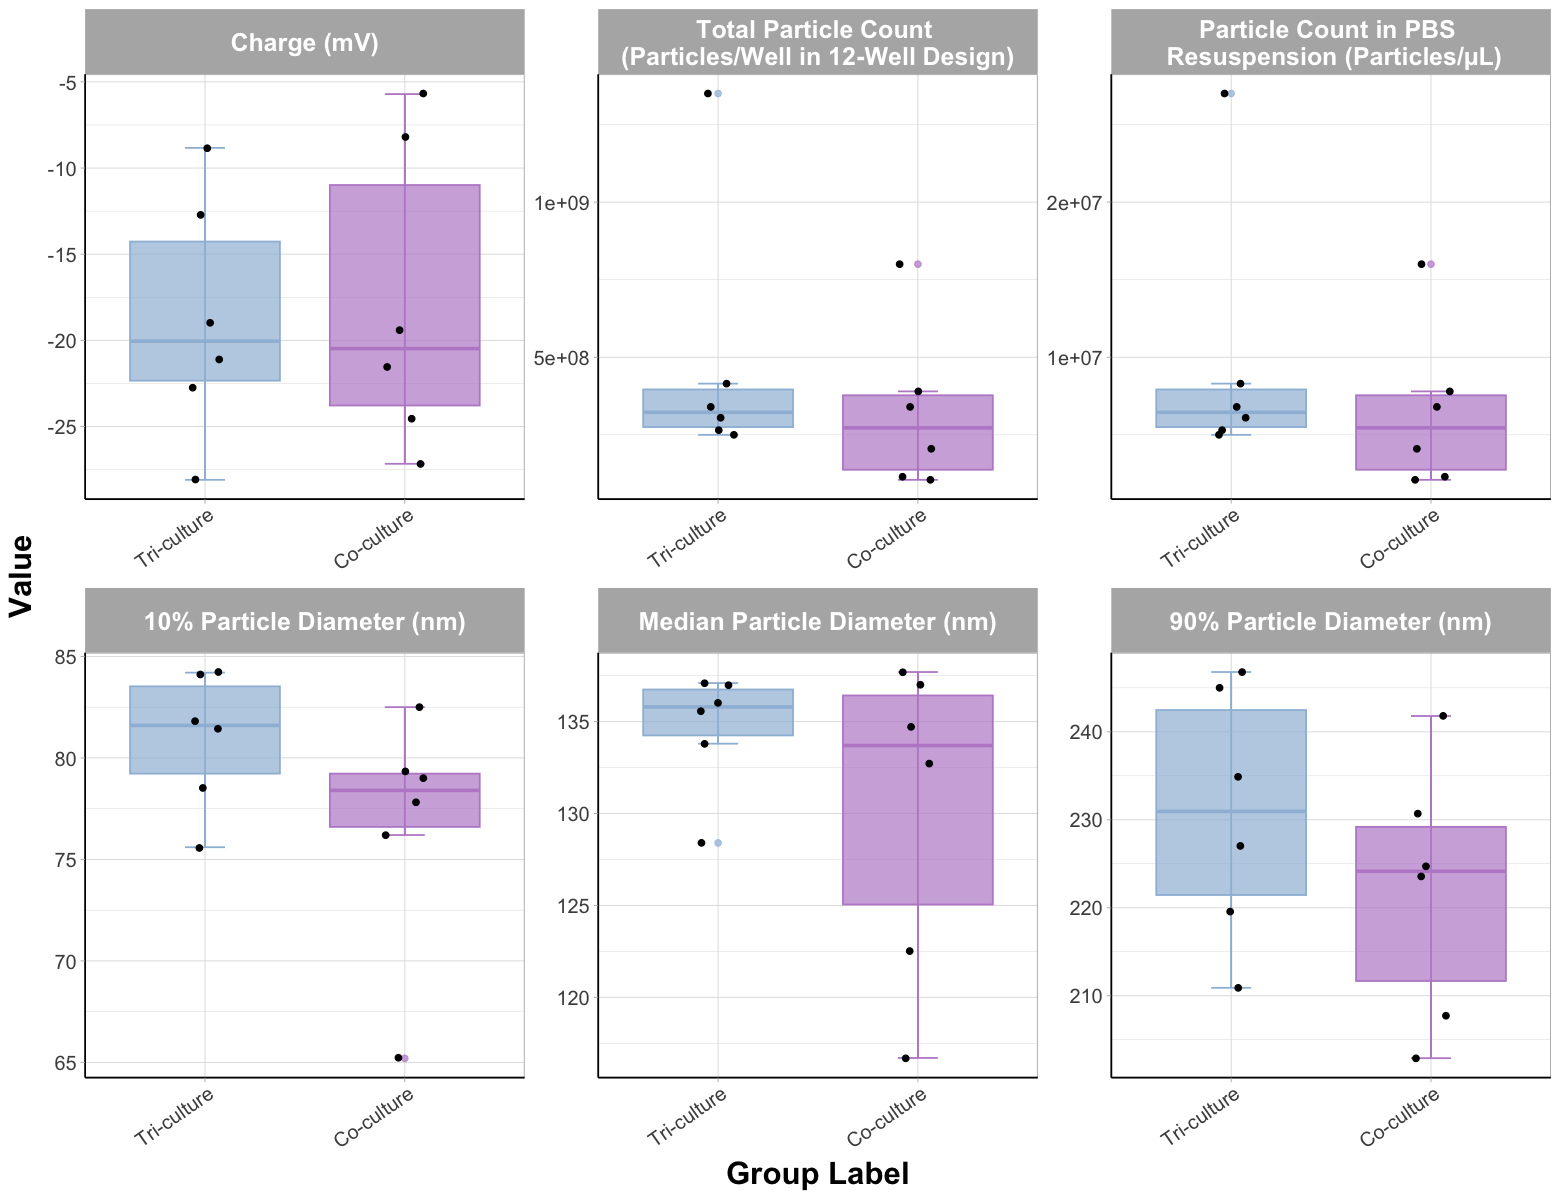

In [5]:
options(repr.plot.width=13, repr.plot.height=10) #changing size
Figure2 = ggplot(data = longer_pdf_data, aes(x = Group.Label, y = Value)) + 
  stat_boxplot(geom = "errorbar", width = 0.2, aes(color = Group.Label)) + # changes width of whiskers
  geom_boxplot(aes(color = Group.Label, fill = Group.Label), alpha = 0.7) + 
  geom_point(position = position_jitter(w = 0.1), alpha = 1) + 
  
  facet_wrap(~Variable, scales = "free", labeller = as_labeller(facet_names)) + 

  theme_light() + 
  theme(axis.text.x = element_text(angle = 35, hjust = 0.97), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.position = "none",
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  xlab('Group Label') + ylab('Value') + 

scale_color_manual(values = c('#9ebcda','#bb8bce')) +
scale_fill_manual(values = c('#9ebcda','#bb8bce'))

Figure2

In [6]:
# # exporting figure
# ggsave(Figure2, 
#        filename = 'Figure 2.pdf',
#        path = Output,
#        width = 15, height = 10)

# Wilcoxon Rank Sum Tests

Typically, normality and homogeneity of variances would be tested for first, however a non-parametric test (Wilcoxon rank sum) will be used given the small sample size (n = 6) to determine if there are statistically significant distribution differences in co-culture and tri-culture groups.

In [7]:
# first normalizing data
normalized_df = longer_pdf_data %>%
    group_by(Group.Label, Variable) %>%
    mutate(Norm_Value = scale(Value))
head(normalized_df)

Sample.Identifier.NTA.PDF,Group.Label,Variable,Value,Norm_Value
<chr>,<fct>,<fct>,<dbl>,"<dbl[,1]>"
20220201_0000_sample1_size,Co-culture,Original.Concentration..Particles..µL.,2.100e+06,-0.8506550
20220201_0000_sample1_size,Co-culture,Particle.Count,1.050e+08,-0.8506550
20220201_0000_sample1_size,Co-culture,X10,7.900e+01,0.3895459
20220201_0000_sample1_size,Co-culture,X50,1.327e+02,0.2884757
20220201_0000_sample1_size,Co-culture,X90,2.029e+02,-1.3131145
20220201_0000_sample1_size,Co-culture,Charge..mV.,-8.180e+00,1.0866308


In [8]:
# iterating through each variable
unique_variable = as.character(unique(normalized_df$Variable))

wilcox_df = data.frame()
for(i in 1:length(unique_variable)){
        # coculture df
        coculture_df = normalized_df %>%
            filter(Group.Label == "Co-culture", Variable == unique_variable[i])

        # triculture df
        triculture_df = normalized_df %>%
            filter(Group.Label == "Tri-culture", Variable == unique_variable[i])

        # wilcox test
        wilcox_test = wilcox.test(coculture_df$Norm_Value, triculture_df$Norm_Value)

        # contains variable, u stat, and p value
        values_vector = cbind(unique_variable[i], wilcox_test$statistic, wilcox_test$p.value)
        wilcox_df = rbind(wilcox_df, values_vector)
}


# adding col names
colnames(wilcox_df) = c("Variable", "Statistic", "P Value")

wilcox_df

,Variable,Statistic,P Value
,<chr>,<chr>,<chr>
W,Original.Concentration..Particles..µL.,17,0.937229437229437
W1,Particle.Count,17,0.937229437229437
W2,X10,18,1
W3,X50,20,0.818181818181818
W4,X90,18,1
W5,Charge..mV.,17,0.937229437229437


In [9]:
# exporting
write.xlsx(wilcox_df, paste0(Output,"/", "PDF_Data Wilcoxon_Results_", cur_date, ".xlsx"), 
           rowNames = FALSE)